In this notebook I provide a demo for classification of ECG data.  
It should be run from this docker (see installation instructions in the repo):  
https://github.com/bellonet/docker-demo-jupyter-mongo

ECG data source:  
https://zenodo.org/record/5711347#.YxttUdVBzJV  
Dataset: ECG Rhythm LEAD I  
It's a part of the PTB-XL dataset:  
https://physionet.org/content/ptb-xl/1.0.2/


Analysis was copied from:   
https://github.com/spdrnl/ecg/blob/master/ECG.ipynb

In [ ]:
import pymongo

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
#from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl
mpl.style.use('seaborn')

### Getting ECG database from MongoDB
If you opened the notebook directly after initializing the container the DB might still be populating. This should take about a minute, maybe it's a good time to go make a coffee.

In [ ]:
# Connection with mongo client - host name and port:
client = pymongo.MongoClient('mongohost', 27017)

In [13]:
# List all databases: 
# If this line takes time to execute - the database is still populating. Please wait a minute and run again.
client.list_database_names()

['admin', 'config', 'ecg_db', 'local']

In [60]:
# Get the ECG database:
db = client['ecg_db']

MongoDB stores data records as *documents*, which are gathered together in *collections*.   
A database stores one or more collections of documents.

In [36]:
# in ecg_db the documents are stored in the "patients" collection:
coll = db["patients"]

### Viewing the dataset:

In [37]:
# Count how many patients are stored in the collection:
coll.count_documents({})

21837

In [39]:
## See whoch fields each patient has:
## Commented as the time-series field is a long list (very long output)

#coll.find_one()

#### outputed fields:
## _id
## ecg_id -         values - positive integer
## age -            values - positive integer / -1
## sex -            values - 0 / 1 / -1
## height           values - positive integer / -1
## rhythm_diag      values - SR / OTHER / AFIB
## time-series      Values - Float array of len 1000

In [40]:
## Slicing example - selecting all the records belonging to a specific criterion:
## In this case age larger than (lt) 50 and sex==0.
## For those records we get a list of the diagnosis and a list of the time-series.
## As time-series is a list per patient that creates a list of lists.

diags = list()
signals = list()
for e in coll.find({"age": {"$lt": 50}, "sex": 0}):
    diags.append(e["rhythm_diag"])
    signals.append(e["time-series"])

In [42]:
# List of lists to np array:
signals = np.array(signals)
signals.shape

(2736, 1000)

In [44]:
len(diags)

2736

Text(0.5, 1.0, 'Distribution of rhythm_diag \n for patients sex=0, age>50')

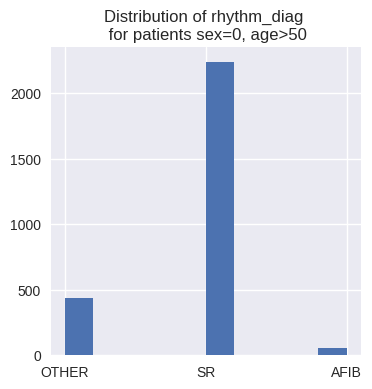

In [67]:
plt.figure(figsize=(4,4))
plt.hist(diags)
plt.title("Distribution of rhythm_diag \n for patients sex=0, age>50")

# SR - Sinus Rhythm, AFIB - Atrial Fibrillation

Text(0.5, 1.0, 'example time-series signal from one patient')

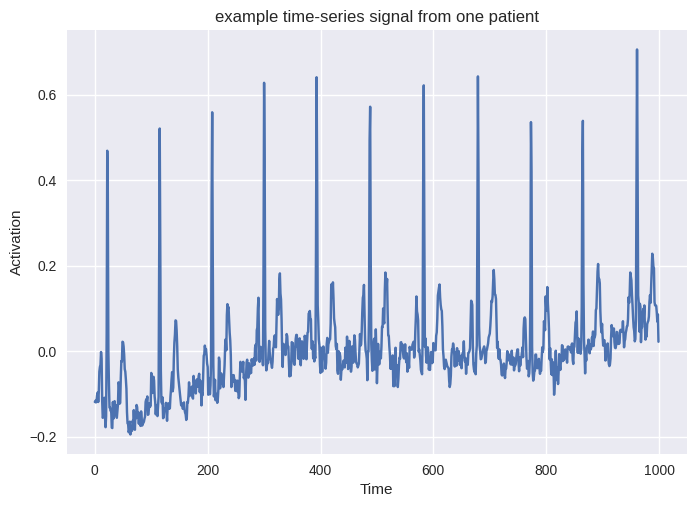

In [84]:
plt.plot(signals[0])
plt.xlabel('Time')
plt.ylabel('Activation')
plt.title("example time-series signal from one patient")

### Analysis
The entire dataset will be used for the analysis (divided to train and test)

In [118]:
diags = list()
signals = list()
for e in coll.find({}):
    diags.append(e["rhythm_diag"])
    signals.append(e["time-series"])
    
signals = np.array(signals)

In [119]:
signals.shape, len(diags)

((21837, 1000), 21837)

In [120]:
# diagnosis values - Encode target labels with value between 0 and n_classes-1.
le = sklearn.preprocessing.LabelEncoder()
le.fit(diags)
y = le.transform(diags)

## For the reverse transform - back to string values:
# le.inverse_transform(y)
np.unique(y), y.shape

(array([0, 1, 2]), (21837,))

In [121]:
# Check for nans:
print("There are {} nan values in the time seires data.".format(np.sum(np.isnan(signals))))

There are 0 nan values in the time seires data.


In [122]:
print("The minimum and maximum activation values in the time-series are {}, {}".format(np.min(signals), np.max(signals)))

The minimum and maximum activation values in the time-series are -7.455, 4.398


In [123]:
# train test split:
X_train, X_test, y_train, y_test = train_test_split(signals, y, test_size=0.33, random_state=42)

print('size training set:', X_train.shape, y_train.shape)
print('size testing set:', X_test.shape, y_test.shape)
print('min and max training set:', np.min(X_train), np.max(y_train))
print('min and max testing set:', np.min(X_test), np.max(y_test))

size training set: (14630, 1000) (14630,)
size testing set: (7207, 1000) (7207,)
min and max training set: -7.455 2
min and max testing set: -5.984 2


In [126]:
# Format y to one hot:
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

In [127]:
# Define the model architecture (very basic NN)
def get_base_model(categories=3):
    return keras.Sequential([
        keras.layers.Dense(15, activation='relu', input_shape=[1000], kernel_regularizer=regularizers.l2(0.0001)),
        keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        keras.layers.Dense(5, activation='relu'),
        keras.layers.Dense(3, activation='softmax')                   
  ])

In [132]:
# Define model params 
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model = get_base_model() 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, batch_size=256, epochs=50)

Epoch 1/50
58/58 [==============================] - 1s 2ms/step - loss: 1.0505 - accuracy: 0.6735
Epoch 2/50
58/58 [==============================] - 0s 3ms/step - loss: 0.8491 - accuracy: 0.7677
Epoch 3/50
58/58 [==============================] - 0s 3ms/step - loss: 0.7093 - accuracy: 0.7679
Epoch 4/50
58/58 [==============================] - 0s 2ms/step - loss: 0.6695 - accuracy: 0.7686
Epoch 5/50
58/58 [==============================] - 0s 2ms/step - loss: 0.6505 - accuracy: 0.7694
Epoch 6/50
58/58 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.7722
Epoch 7/50
58/58 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.7754
Epoch 8/50
58/58 [==============================] - 0s 3ms/step - loss: 0.5979 - accuracy: 0.7805
Epoch 9/50
58/58 [==============================] - 0s 3ms/step - loss: 0.5801 - accuracy: 0.7865
Epoch 10/50
58/58 [==============================] - 0s 3ms/step - loss: 0.5624 - accuracy: 0.7921
Epoch 11/50
58/58 [

In [139]:
# Predict on test data:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

226/226 [==============================] - 0s 1ms/step


In [162]:
# Print classification metrics:
print(sklearn.metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.10      0.13      0.11       493
           1       0.26      0.24      0.25      1161
           2       0.81      0.79      0.80      5553

    accuracy                           0.66      7207
   macro avg       0.39      0.39      0.39      7207
weighted avg       0.67      0.66      0.66      7207

